# Customer Segmentation

The purpose of this note book is to analyze a data set which contains transactions occurring for a UK-based and registered, e-commerce website between 01/12/2009 and 09/12/2011. The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. **Three objectives that I have for this data include:** exploring the data and getting a feel for it, to make new and perhaps more useful features using the existing data and finally, to classify customers into groups using various methods and comparing the results to see which method does best.
____________________________________________________________

# **Table of Contents**

1 -- Exploring and Visualizing The Data


2 -- Creating Clusters of Products


3 -- Creating Customer Categories


4 -- Preparations For Machine Learning


5 -- Classifiction of Customers


6 -- Testing The Predictions


7 -- Conclusion 


# **1. Exploring and Visualizing The Data:**


**Below are the variables given by the data set:**

**Invoice**: Stands for invoice number. String object. A 6-digit number uniquely assigned to each transaction. A cancellation is indicated with a code that starts with the letter “c”.

**StockCode**: Product code. String object. A 5-digit number that is uniquely assigned to each distinct product. 

**Description**: Product name. String Object. 

**Quantity**: The quantities of each product per transaction. int64. 

**InvoiceDate**: Invoice date and time. String object. The day and time when a transaction was generated. 

**Price**: Unit price. Float64. Price per unit in pound sterling (£). 

**Customer** **ID**: Customer ID number. Float64. A 5-digit number that is uniquely assigned to each customer. 

**Country**: Country name. String object. The name of the country where a customer resides. This data set only contains customers from the United Kingdom.


In [4]:
import dill
import numpy as np 
import pandas as pd 
import os

#dill.load_session('RetailV21M1.db')

RETAIL_PATH = os.path.join("datasets", "Online Retail")

def load_retail_data(retail_path=RETAIL_PATH):
    csv_path = os.path.join(retail_path, "online_retail_II.csv") 
    return pd.read_csv(csv_path) # returning a Pandas data frame.

retail = load_retail_data(RETAIL_PATH)
retail.insert(0, 'id', range(0, 0 + len(retail)))
retail.head()


,id,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


By taking a look at the null values in the dataset as shown below, we see that around 23% of the customer IDs are missing. This renders these rows useless because we cannot represent customers who are missing IDs using the actions that are listed in the data. On top of that, these rows will be useless in regard to our objectives. Thus, we must delete these rows of the data. 


In [5]:
info1=pd.DataFrame(retail.dtypes).T.rename(index={0:'column type'})
info1=info1.append(pd.DataFrame(retail.isnull().sum()).T.rename(index={0:'null values (nb)'}))
info1=info1.append(pd.DataFrame(retail.isnull().sum()/retail.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(info1)

,id,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column type,int64,object,object,object,int64,object,float64,float64,object
null values (nb),0,0,0,4382,0,0,0,243007,0
null values (%),0.0,0.0,0.0,0.410541,0.0,0.0,0.0,22.766873,0.0


In [6]:
retail.dropna(axis = 0, subset = ['Customer ID'], inplace = True) 

In [7]:
info2=pd.DataFrame(retail.dtypes).T.rename(index={0:'column type'})
info2=info2.append(pd.DataFrame(retail.isnull().sum()).T.rename(index={0:'null values (nb)'}))
info2=info2.append(pd.DataFrame(retail.isnull().sum()/retail.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(info2)

,id,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column type,int64,object,object,object,int64,object,float64,float64,object
null values (nb),0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Duplicates are dropped:

In [8]:
retail.drop_duplicates(inplace = True)

In [9]:
pd.DataFrame([{'products': len(retail['StockCode'].value_counts()),'transactions': len(retail['Invoice'].value_counts()),
               'customers': len(retail['Customer ID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4646,44876,5942


There are 5942 customers in total who bought 4646 unique products. In total, there were 44876 transactions. 

There are three interesting types of people: Those who buy 1 product, those who buy many and those who have cancelled their order.


In [10]:
info3 = retail.groupby(by=['Customer ID', 'Invoice'], as_index=False)['InvoiceDate'].count()
productsPerBasket = info3.rename(columns = {'InvoiceDate':'Number of products'})
productsPerBasket[:10].sort_values('Customer ID')

,Customer ID,Invoice,Number of products
0,12346.0,491725,1
1,12346.0,491742,1
2,12346.0,491744,1
3,12346.0,492718,1
4,12346.0,492722,1
5,12346.0,493410,1
6,12346.0,493412,1
7,12346.0,494450,1
8,12346.0,495295,1
9,12346.0,499763,5


We can also take a look at what percent of the population cancelled their orders.


In [11]:
productsPerBasket['order_canceled'] = productsPerBasket['Invoice'].apply(lambda x:int('C' in x))
display(productsPerBasket[:5])
n1 = productsPerBasket['order_canceled'].sum()
n2 = productsPerBasket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,Customer ID,Invoice,Number of products,order_canceled
0,12346.0,491725,1,0
1,12346.0,491742,1,0
2,12346.0,491744,1,0
3,12346.0,492718,1,0
4,12346.0,492722,1,0


Number of orders canceled: 7901/44876 (17.61%) 


Upon further inspection of the data, we come upon an issue. The image below describes the issue where you will come across two rows with the same customer involved. Except one row will
detail a buy and the other a cancellation of the same product and amount. This will need to be fixed.

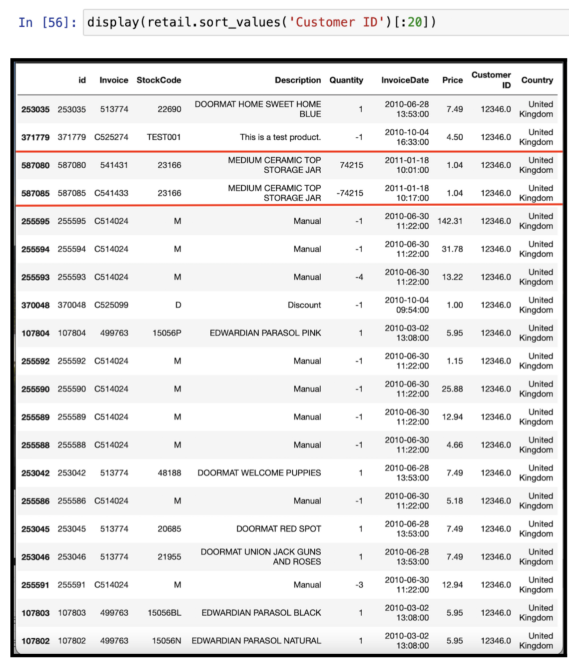

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.figure(figsize=(12,12))
plt.axis('off')
img= mpimg.imread('/Users/ayaznakhuda/Documents/ml/RetailPic1.png')
imgplot = plt.imshow(img)

To delete the problematic rows, we look for rows that have a negative counterpart in the Quantity column. We then delete the row with the negative counterpart. 


In [14]:
dfCleaned = retail.copy(deep = True)
dfCleaned['QuantityCanceled'] = 0
entryToRemove = []


for index, col in  retail.iterrows():
    
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue    #if the quantity is greater than 0 or the description matches discount.    
    df_test = retail[(retail['Customer ID'] == col['Customer ID']) &
                         (retail['StockCode']  == col['StockCode']) & 
                         (retail['InvoiceDate'] < col['InvoiceDate']) & 
                         (retail['Quantity']   > 0)].copy()

    if (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        dfCleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entryToRemove.append(index)        

    # Counterparts can exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            dfCleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entryToRemove.append(index) 
            break   
            
            
print("entryToRemove: {}".format(len(entryToRemove)))

entryToRemove: 16495


In [16]:
dill.dump_session('RetailV21M1.db')

In [17]:
display(dfCleaned.sort_values('Customer ID')[:20])

,id,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,QuantityCanceled
253035,253035,513774,22690,DOORMAT HOME SWEET HOME BLUE,1,2010-06-28 13:53:00,7.49,12346.0,United Kingdom,0
371779,371779,C525274,TEST001,This is a test product.,-1,2010-10-04 16:33:00,4.50,12346.0,United Kingdom,0
587080,587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215
587085,587085,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,0
255595,255595,C514024,M,Manual,-1,2010-06-30 11:22:00,142.31,12346.0,United Kingdom,0
255594,255594,C514024,M,Manual,-1,2010-06-30 11:22:00,31.78,12346.0,United Kingdom,0
255593,255593,C514024,M,Manual,-4,2010-06-30 11:22:00,13.22,12346.0,United Kingdom,0
370048,370048,C525099,D,Discount,-1,2010-10-04 09:54:00,1.00,12346.0,United Kingdom,0
107804,107804,499763,15056P,EDWARDIAN PARASOL PINK,1,2010-03-02 13:08:00,5.95,12346.0,United Kingdom,0
255592,255592,C514024,M,Manual,-1,2010-06-30 11:22:00,1.15,12346.0,United Kingdom,0


Each row represents customers buying a specific type of product. Therefore, orders can span multiple rows and we want to combine these rows to represent the order made by the customers.  The total amount of money spent on each order is also recorded. The average invoice date is recorded as for some orders, the date varies usually by a small amount.

In [3]:
dfCleaned['TotalPrice'] = dfCleaned['Price'] * (dfCleaned['Quantity'] - dfCleaned['QuantityCanceled'])

temp = dfCleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['TotalPrice'].sum()
cartPrice = temp.rename(columns = {'TotalPrice':'Cart Price'})

# date of the command
dfCleaned['invoiceDateInt'] = pd.to_datetime(dfCleaned['InvoiceDate']).values.astype(np.int64)
temp = dfCleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['invoiceDateInt'].mean() 
dfCleaned.drop('invoiceDateInt', axis = 1, inplace = True)
cartPrice.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['invoiceDateInt'])

# selection of significant entries:
cartPrice = cartPrice[cartPrice['Cart Price'] > 0]
cartPrice.sort_values('Customer ID')[:6]

,Customer ID,Invoice,Cart Price,InvoiceDate
0,12346.0,491725,45.0,2009-12-14 08:34:00
1,12346.0,491742,22.5,2009-12-14 11:00:00
2,12346.0,491744,22.5,2009-12-14 11:02:00
3,12346.0,492718,22.5,2009-12-18 10:47:00
4,12346.0,492722,1.0,2009-12-18 10:55:00
5,12346.0,493410,22.5,2010-01-04 09:24:00


In [4]:
display(dfCleaned[:20])

,id,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,QuantityCanceled,TotalPrice
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0,83.40
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0,81.00
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0,81.00
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0,100.80
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0,30.00
5,5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,0,39.60
6,6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0,30.00
7,7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,0,59.50
8,8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,0,30.60
9,9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,0,45.00


In [5]:
display(cartPrice[:20])

,Customer ID,Invoice,Cart Price,InvoiceDate
0,12346.0,491725,45.00,2009-12-14 08:34:00.000000000
1,12346.0,491742,22.50,2009-12-14 11:00:00.000000000
2,12346.0,491744,22.50,2009-12-14 11:02:00.000000000
3,12346.0,492718,22.50,2009-12-18 10:47:00.000000000
4,12346.0,492722,1.00,2009-12-18 10:55:00.000000000
5,12346.0,493410,22.50,2010-01-04 09:24:00.000000000
6,12346.0,493412,22.50,2010-01-04 09:53:00.000000000
7,12346.0,494450,22.50,2010-01-14 13:50:00.000000000
8,12346.0,495295,18.00,2010-01-22 13:30:00.000000000
9,12346.0,499763,27.05,2010-03-02 13:08:00.000000000


We then take a look at the proportion of people per each spending category:

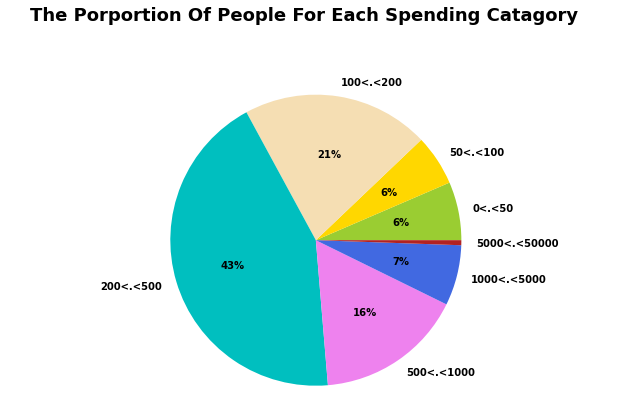

In [6]:
import matplotlib.pyplot as plt
priceRange = [0, 50, 100, 200, 500, 1000, 5000, 50000]
countPrice = []

for i, price in enumerate(priceRange):
    if i == 0: continue
    val = cartPrice[(cartPrice['Cart Price'] < price) &
                       (cartPrice['Cart Price'] > priceRange[i-1])]['Cart Price'].count()
    countPrice.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(priceRange[i-1], s) for i,s in enumerate(priceRange) if i != 0]
sizes  = countPrice
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '', shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "The Porportion Of People For Each Spending Catagory", ha='center', fontsize = 18);

In [7]:
is_noun = lambda pos: pos[:2] == 'NN'


def keywordsInventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywordsRoots  = dict()  
    keywordsSelect = dict()  
    categoryKeys   = []
    countKeywords  = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; root = stemmer.stem(t)
            if root in keywordsRoots:                
                keywordsRoots[root].add(t)
                countKeywords[root] += 1                
            else:
                keywordsRoots[root] = {t}
                countKeywords[root] = 1
    
    for s in keywordsRoots.keys():
        if len(keywordsRoots[s]) > 1:  
            min_length = 1000
            for k in keywordsRoots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            categoryKeys.append(clef)
            keywordsSelect[s] = clef
        else:
            categoryKeys.append(list(keywordsRoots[s])[0])
            keywordsSelect[s] = list(keywordsRoots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format(column,len(categoryKeys)))
    return categoryKeys, keywordsRoots, keywordsSelect, countKeywords

We then analyze the description variable using nltk (natural language toolkit).

In [8]:
import nltk

dfProducts = pd.DataFrame(dfCleaned['Description'].unique()).rename(columns = {0:'Description'})

In [9]:
keywords, keywordsRoots, keywordsSelect, countKeywords = keywordsInventory(dfProducts)

Number of keywords in variable 'Description': 1730


In [10]:
listProducts = []
for k,v in countKeywords.items():
    listProducts.append([keywordsSelect[k],v])
listProducts.sort(key = lambda x:x[1], reverse = True)

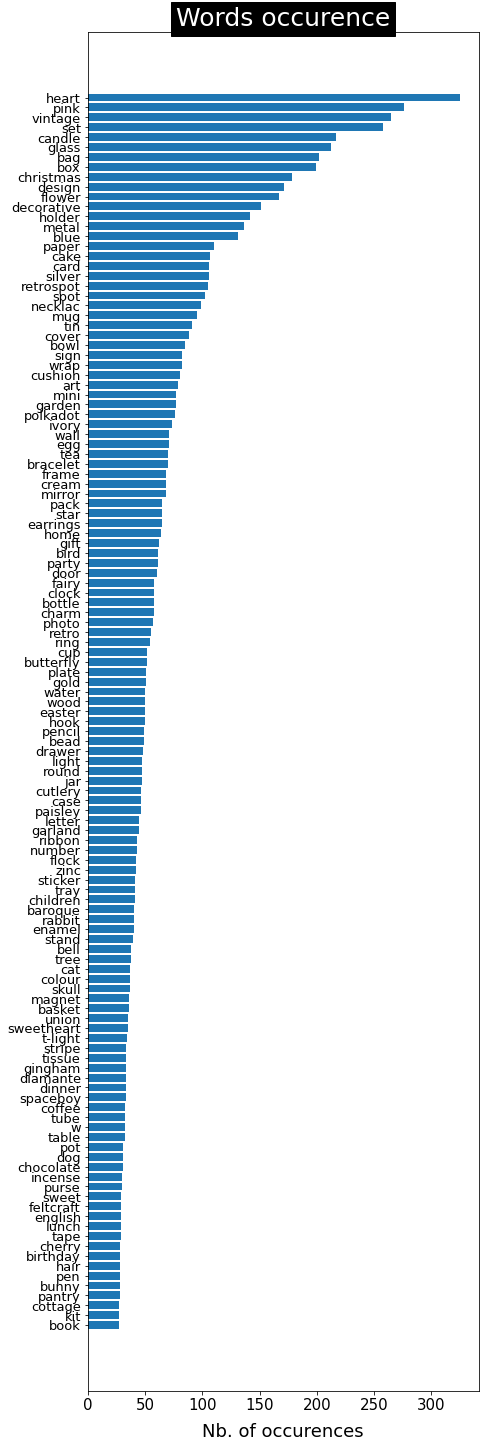

In [11]:
list = sorted(listProducts, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list[:125]]
x_axis = [k for k,i in enumerate(list[:125])]
x_label = [i[0] for i in list[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

This seems pretty good however, there are some words that are useless for analysis such as colours and short words. Words that appear less will also be removed.

In [12]:
listProducts = []
for k,v in countKeywords.items():
    word = keywordsSelect[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    listProducts.append([word, v])
  
listProducts.sort(key = lambda x:x[1], reverse = True)
print('Preserved Words:', len(listProducts))

Preserved Words: 261


Here is the new graphic of the words occurrence:


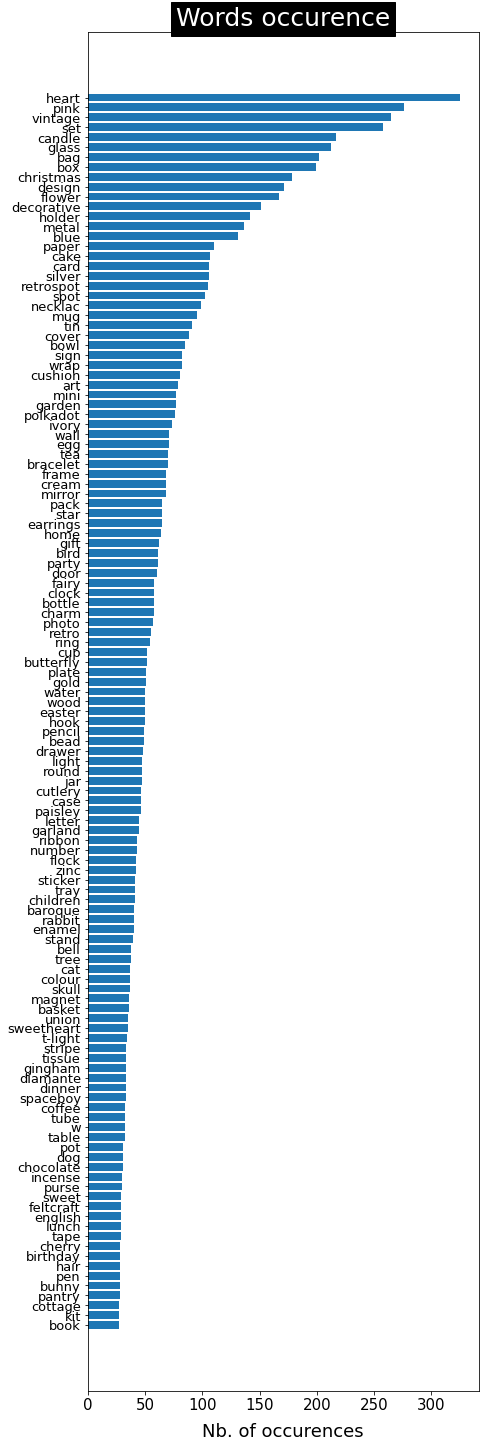

In [13]:
l = sorted(listProducts, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list[:125]]
x_axis = [k for k,i in enumerate(list[:125])]
x_label = [i[0] for i in list[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [14]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 824364 entries, 0 to 1067370
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                824364 non-null  int64  
 1   Invoice           824364 non-null  object 
 2   StockCode         824364 non-null  object 
 3   Description       824364 non-null  object 
 4   Quantity          824364 non-null  int64  
 5   InvoiceDate       824364 non-null  object 
 6   Price             824364 non-null  float64
 7   Customer ID       824364 non-null  float64
 8   Country           824364 non-null  object 
 9   QuantityCanceled  824364 non-null  int64  
 10  TotalPrice        824364 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 75.5+ MB


These keywords will be used to make groups of products. A matrix will be made with a configuration like the picture below:


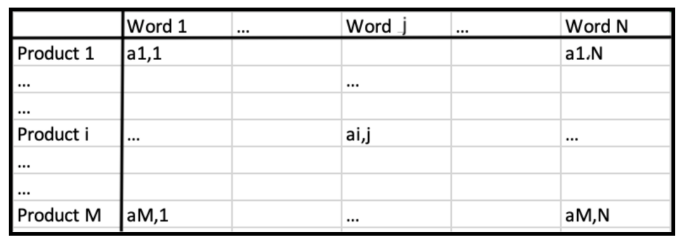

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.figure(figsize=(12,12))
plt.axis('off')
img = mpimg.imread('/Users/ayaznakhuda/Documents/ml/RetailPic2.png')
imgplot = plt.imshow(img)

A 1 will be present in a cell if the word appears in this specific product's description.

In [19]:
productList = dfCleaned['Description'].unique()
X = pd.DataFrame() 



for key, occurence in listProducts:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), productList))
    # we are applying the lambda function to each item of the productList iterable

We will also add 6 more columns to this matrix detailing which price category the products lie in.


In [21]:
threshold = [0, 1, 2, 3, 5, 10] 
labelCol = [] 
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    labelCol.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(productList):
    price = dfCleaned[ dfCleaned['Description'] == prod]['Price'].mean()
    j = 0
    while price > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, labelCol[j-1]] = 1


In [22]:
print("{:<8} {:<20} \n".format('range', 'nb. products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    nb. products         
--------------------
0<.<1       1152                
1<.<2       1408                
2<.<3       939                 
3<.<5       860                 
5<.<10      679                 
.>10        261                 


# **2. Creating Clusters of Products:**

We want to see the best choice for the number of clusters to have for our data. So we take a look at the average silhouette scores.


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

matrix = X.to_numpy()
matrix

for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.08988436966058097
For n_clusters = 4 The average silhouette_score is : 0.11294093901715804
For n_clusters = 5 The average silhouette_score is : 0.13130082560089865
For n_clusters = 6 The average silhouette_score is : 0.13143444498496434
For n_clusters = 7 The average silhouette_score is : 0.13217978554358578
For n_clusters = 8 The average silhouette_score is : 0.12787569751781822
For n_clusters = 9 The average silhouette_score is : 0.12592437051825542


For 5, 6 and 7 clusters, we get some of the best average silhouette scores. Let us see if there is an appropriate number of items in each cluster (for 5, 6, and 7 clusters).

In [27]:
n_clusters = 6
silhouette_avg = -1

while silhouette_avg < 0.132:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
    
pd.Series(clusters).value_counts()

For n_clusters = 6 The average silhouette_score is : 0.13143444498496434
For n_clusters = 6 The average silhouette_score is : 0.12058865758932623
For n_clusters = 6 The average silhouette_score is : 0.13164730614347853
For n_clusters = 6 The average silhouette_score is : 0.1301978999348716
For n_clusters = 6 The average silhouette_score is : 0.13142505631712412
For n_clusters = 6 The average silhouette_score is : 0.12919807394104244
For n_clusters = 6 The average silhouette_score is : 0.12806569905470577
For n_clusters = 6 The average silhouette_score is : 0.1321403965233085


3    1408
0    1152
1     939
2     860
5     679
4     261
dtype: int64

In [28]:
n_clusters = 7
silhouette_avg = -1

while silhouette_avg < 0.132:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
    
pd.Series(clusters).value_counts()

For n_clusters = 7 The average silhouette_score is : 0.12767112038324088
For n_clusters = 7 The average silhouette_score is : 0.12906515091520024
For n_clusters = 7 The average silhouette_score is : 0.12419546553606428
For n_clusters = 7 The average silhouette_score is : 0.12625342066977233
For n_clusters = 7 The average silhouette_score is : 0.1280514480626691
For n_clusters = 7 The average silhouette_score is : 0.12937023868428474
For n_clusters = 7 The average silhouette_score is : 0.12770982061312772
For n_clusters = 7 The average silhouette_score is : 0.12904772948477658
For n_clusters = 7 The average silhouette_score is : 0.13436733559038408


1    1379
2    1127
3     902
6     822
4     669
0     257
5     143
dtype: int64

In [31]:
n_clusters = 5
silhouette_avg = -1

while silhouette_avg < 0.132:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
pd.Series(clusters).value_counts()

For n_clusters = 5 The average silhouette_score is : 0.13113318818462097
For n_clusters = 5 The average silhouette_score is : 0.11103863873795199
For n_clusters = 5 The average silhouette_score is : 0.13130082560089865
For n_clusters = 5 The average silhouette_score is : 0.1294372327516531
For n_clusters = 5 The average silhouette_score is : 0.13081078818005273
For n_clusters = 5 The average silhouette_score is : 0.13081078818005273
For n_clusters = 5 The average silhouette_score is : 0.13130082560089865
For n_clusters = 5 The average silhouette_score is : 0.12952361095604562
For n_clusters = 5 The average silhouette_score is : 0.13130082560089865
For n_clusters = 5 The average silhouette_score is : 0.13081078818005273
For n_clusters = 5 The average silhouette_score is : 0.1294372327516531
For n_clusters = 5 The average silhouette_score is : 0.11395750078703555
For n_clusters = 5 The average silhouette_score is : 0.11140529407382563
For n_clusters = 5 The average silhouette_score is : 

KeyboardInterrupt: 

We can see from the keyboard interrupt I did, it can take a while for the average silhouette score to be greater than or equal to 0.132 when compared to n = 6 and n = 7. I would say that having 5 clusters is better than having 7 because for n = 7, there appears to be two clusters with few items. Having 5 clusters also seems to be better than 6 when you compare the cluster with the lowest number of items. The lowest number of items in a cluster when n = 5 is 369 which is better than 261 for when n = 6. Thus, I will use n = 5 from now on, as it has a relatively good average silhouette score and it has a good number of items in each cluster.


In [32]:
pd.Series(clusters).value_counts()

0    1686
1    1299
2    1065
3     880
4     369
dtype: int64

In [36]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sampleSilhouetteValues, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sampleSilhouetteValues[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.8)
        # Labeling the silhouette plots with their cluster numbers in the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        y_lower = y_upper + 10 

Here we can see the silhouette score for each category when there are 5 clusters:


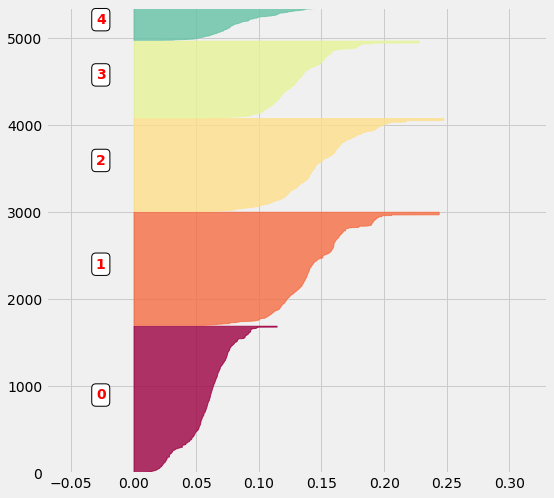

In [37]:
import matplotlib as mpl
import matplotlib.cm as cm

sampleSilhouetteValues = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sampleSilhouetteValues, clusters)

In [38]:
lst = pd.DataFrame(productList)
listWords = [word for (word, occurence) in listProducts]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = lst.loc[clusters == i]
    for word in listWords:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

Now let us get a general look at the words in each cluster.


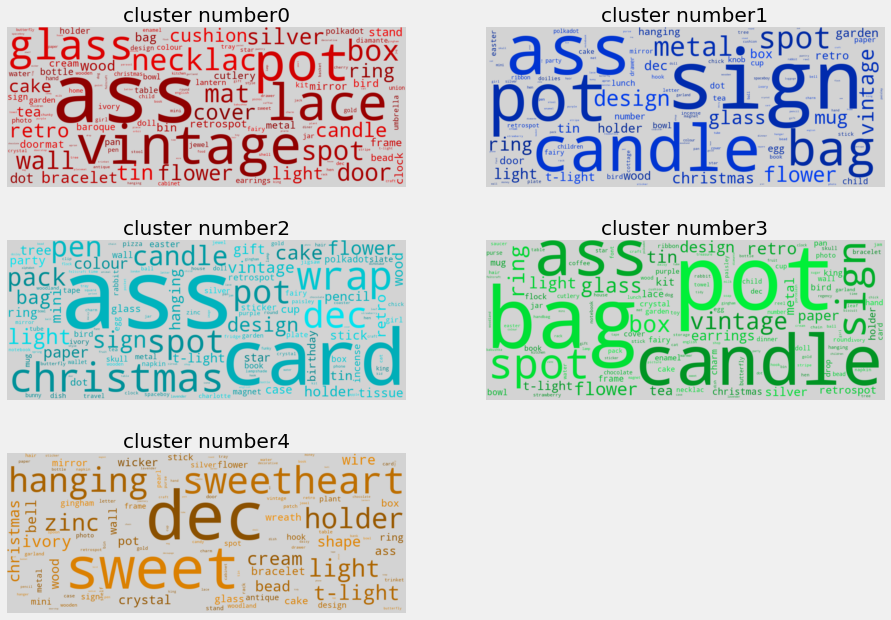

In [41]:
from wordcloud import WordCloud, STOPWORDS


def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


def make_wordcloud(lst, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = lst[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster number{}'.format(increment-1))

    
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]


for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i]
    lst = []
    for key, value in list_cluster_occurences.items():
        lst.append([key, value])
    lst.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(lst, i+1)   

**Cluster 0:** There appears to be words which describe home decor in this cluster.

**Cluster 1:** There seems to be many words that relate to dishes in this cluster.

**Cluster 2:** This cluster appears to have words that relate to Christmas and gifts. 

**Cluster 3:** This cluster is hard to make out due to the various words that are shared with other clusters.

**Cluster 4:** This cluster may have words that associate with Valintine's day. 



Overall, it is quite difficult to pinpoint exactly what the theme is with each cluster. This can be attributed to words being prevalent in multiple clusters.


A **Principal Component Analysis (PCA)** is typically done to reduce the dimensionality of the data. This graphic will show you the components that are most/least accountable for explained variance of the overall variability. 

For more information about PCA’s you can check out this youtube video:
https://www.youtube.com/watch?v=FgakZw6K1QQ by StatQuest. 


And for more information about variance and the principle components in PCA, please see this post on stack exchange:
https://stats.stackexchange.com/questions/22569/pca-and-proportion-of-variance-explained


In [40]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

The graphic below shows us that it takes over 100 principle components to explain 90% of the variance of the data.


/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


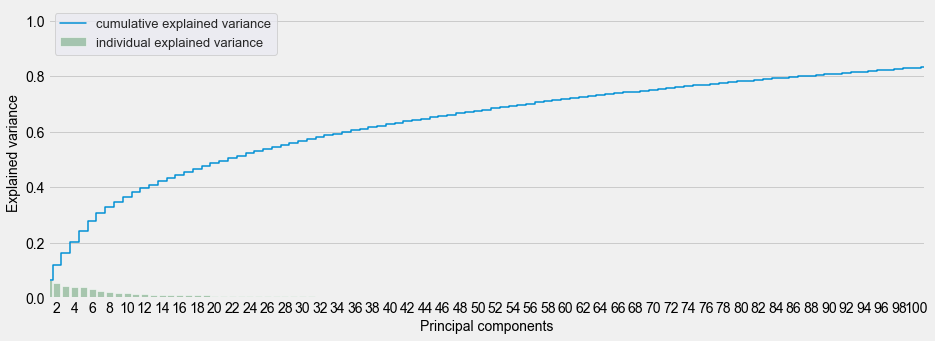

In [42]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);


In [43]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

We will take a few of these components and use them to help us visualize the data further.


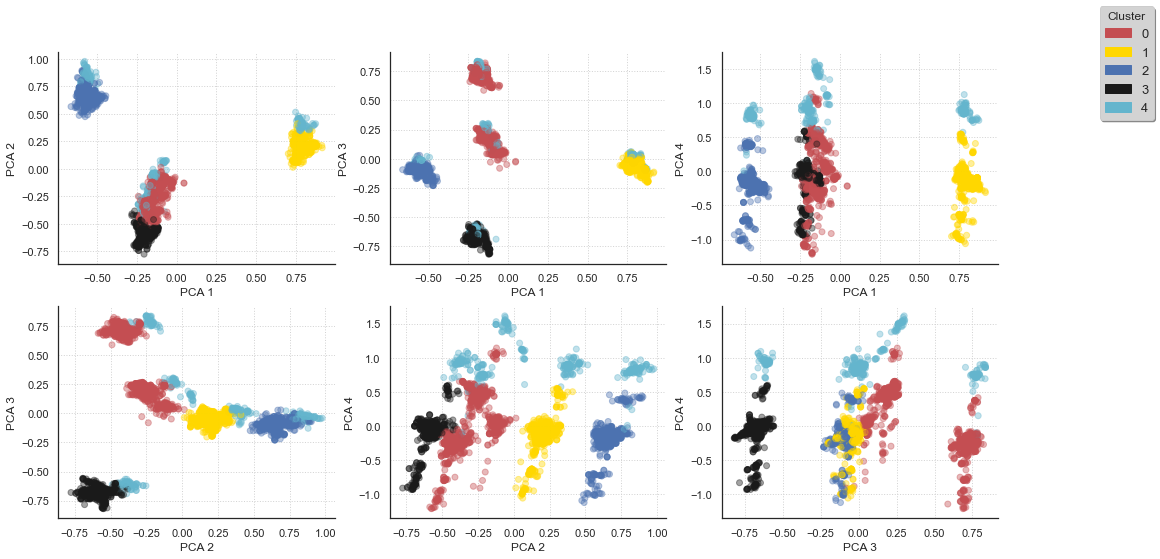

In [44]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
labelColour = [LABEL_COLOR_MAP[l] for l in mat['cluster']]
fig = plt.figure(figsize = (15,8))
increment = 0


for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= labelColour, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        

comp_handler = []

for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()



In [45]:
corresp = dict()

for key, val in zip (productList, clusters):
    corresp[key] = val 
    
dfCleaned['categ_product'] = dfCleaned.loc[:, 'Description'].map(corresp)


# **3. Creating Customer Categories**

In the previous section, we were able to put certain products in categories and come up with additional information. We now want to combine this additional information with the information that is present in the df_cleaned dataframe.

In this section, we will combine the new variables that were made and the information already present in the retail data frame from the previous section.


The category column representing which category a purchased product lies in along with a column that details the amount spent in each product category has been made.


In [46]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = dfCleaned[dfCleaned['categ_product'] == i]
    price_temp = df_temp['Price'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    dfCleaned.loc[:, col] = price_temp
    dfCleaned[col].fillna(0, inplace = True)

dfCleaned[['Invoice', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,Invoice,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,0,83.4,0.0,0.0,0.0,0.0
1,489434,PINK CHERRY LIGHTS,0,81.0,0.0,0.0,0.0,0.0
2,489434,WHITE CHERRY LIGHTS,0,81.0,0.0,0.0,0.0,0.0
3,489434,"RECORD FRAME 7"" SINGLE SIZE",3,0.0,0.0,0.0,100.8,0.0
4,489434,STRAWBERRY CERAMIC TRINKET BOX,1,0.0,30.0,0.0,0.0,0.0


In [47]:
temp = dfCleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['TotalPrice'].sum()

cartPrice = temp.rename(columns = {'TotalPrice':'Cart Price'})

for i in range(5):
    col = 'categ_{}'.format(i) 
    temp2 = dfCleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)[col].sum()
    cartPrice.loc[:, col] = temp2[col]

Here is a clear picture detailing orders made by customers including the total amount of money they spent and the money they spent on each product category. Also, each row now represents a unique order.

In [48]:
dfCleaned['invoiceDateInt'] = pd.to_datetime(dfCleaned['InvoiceDate']).values.astype(np.int64)
temp = dfCleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['invoiceDateInt'].mean()
dfCleaned.drop('invoiceDateInt', axis = 1, inplace = True)
cartPrice.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['invoiceDateInt'])

cartPrice = cartPrice[cartPrice['Cart Price'] > 0]
cartPrice.sort_values('Customer ID', ascending = True)[:35]

,Customer ID,Invoice,Cart Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12346.0,491725,45.00,45.00,0.00,0.00,0.00,0.00,2009-12-14 08:34:00.000000000
1,12346.0,491742,22.50,22.50,0.00,0.00,0.00,0.00,2009-12-14 11:00:00.000000000
2,12346.0,491744,22.50,22.50,0.00,0.00,0.00,0.00,2009-12-14 11:02:00.000000000
3,12346.0,492718,22.50,22.50,0.00,0.00,0.00,0.00,2009-12-18 10:47:00.000000000
4,12346.0,492722,1.00,1.00,0.00,0.00,0.00,0.00,2009-12-18 10:55:00.000000000
5,12346.0,493410,22.50,22.50,0.00,0.00,0.00,0.00,2010-01-04 09:24:00.000000000
6,12346.0,493412,22.50,22.50,0.00,0.00,0.00,0.00,2010-01-04 09:53:00.000000000
7,12346.0,494450,22.50,22.50,0.00,0.00,0.00,0.00,2010-01-14 13:50:00.000000000
8,12346.0,495295,18.00,18.00,0.00,0.00,0.00,0.00,2010-01-22 13:30:00.000000000
9,12346.0,499763,27.05,27.05,0.00,0.00,0.00,0.00,2010-03-02 13:08:00.000000000


I then perform a check to see if I have done everything correct thus far…


In [49]:
n = len(pd.unique(cartPrice['Invoice']))
print(n)

36664


In [50]:
print(len(cartPrice.index))

36664


And indeed, we do not have any duplicate orders.

Let us see the timespan of the orders of this dataframe:

In [52]:
print(cartPrice['InvoiceDate'].min(), '->',  cartPrice['InvoiceDate'].max())

2009-12-01 07:45:00 -> 2011-12-09 12:50:00


In [53]:
from datetime import datetime,timedelta,date

set_entrainement = cartPrice[cartPrice['InvoiceDate'].dt.date < date(2011,9,1)]
set_test = cartPrice[cartPrice['InvoiceDate'].dt.date >=date(2011,9,1)]
cartPrice2 = set_entrainement.copy(deep = True)

In [56]:
transactions_per_user=cartPrice.groupby(by=['Customer ID'])['Cart Price'].agg(['count','min','max','mean','sum'])
# the line above essentially gets a df in such a way that each row represents a unique customer and the columns
# represent how many orders they placed, the min amount spent, the max, the mean and the sum that they spent.

for i in range(5):# here we will work with the categories.
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = cartPrice.groupby(by=['Customer ID'])[col].sum() /\
                                            transactions_per_user['sum']*100 
    # we are going to add the money spent by each customer in this category 'col'.

transactions_per_user.reset_index(drop = False, inplace = True)
cartPrice.groupby(by=['Customer ID'])['categ_0'].sum()
transactions_per_user.sort_values('Customer ID', ascending = True)[:5]

,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12346.0,11,1.00,142.31,33.487273,368.36,100.000000,0.000000,0.000000,0.000000,0.000000
1,12347.0,8,224.82,1423.58,704.165000,5633.32,40.740096,23.700056,9.977420,20.588214,4.994213
2,12348.0,5,222.16,892.80,403.880000,2019.40,17.876597,36.476181,34.291374,0.000000,11.355848
3,12349.0,4,200.00,1757.55,1107.172500,4428.69,57.263886,17.618302,6.397377,8.165394,10.555040
4,12350.0,1,334.40,334.40,334.400000,334.40,11.961722,48.444976,11.692584,27.900718,0.000000


Here is more data on the transactions per user:

In [57]:
transactions_per_user2=cartPrice.groupby(by=['Customer ID'])['Cart Price'].agg(['count','min','max','mean','sum'])
transactions_per_user2

,count,min,max,mean,sum
Customer ID,,,,,
12346.0,11,1.00,142.31,33.487273,368.36
12347.0,8,224.82,1423.58,704.165000,5633.32
12348.0,5,222.16,892.80,403.880000,2019.40
12349.0,4,200.00,1757.55,1107.172500,4428.69
12350.0,1,334.40,334.40,334.400000,334.40
...,...,...,...,...,...
18283.0,22,1.95,313.65,124.393182,2736.65
18284.0,1,411.68,411.68,411.680000,411.68
18285.0,1,427.00,427.00,427.000000,427.00


This data will also be added into our data frame. The last two variables that will be added to this data frame will the number of days since the first purchase and the number of days since the last purchase.

In [58]:
last_date = cartPrice['InvoiceDate'].max().date()

first_registration = pd.DataFrame(cartPrice.groupby(by=['Customer ID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(cartPrice.groupby(by=['Customer ID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12346.0,11,1.00,142.31,33.487273,368.36,100.000000,0.000000,0.000000,0.000000,0.000000,529,725
1,12347.0,8,224.82,1423.58,704.165000,5633.32,40.740096,23.700056,9.977420,20.588214,4.994213,2,404
2,12348.0,5,222.16,892.80,403.880000,2019.40,17.876597,36.476181,34.291374,0.000000,11.355848,75,438
3,12349.0,4,200.00,1757.55,1107.172500,4428.69,57.263886,17.618302,6.397377,8.165394,10.555040,18,589
4,12350.0,1,334.40,334.40,334.400000,334.40,11.961722,48.444976,11.692584,27.900718,0.000000,310,310


Here is the percent of unique purchases

In [59]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("number of customers with unique purchases: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

number of customers with unique purchases: 1611/5855  (27.51%)


In [60]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

# **4.  Preparations For Machine Learning**

We will take a subset of variables from the transactions_for_user data frame. Because there is variation in the data, we want to standardize it. For more information about standardization of data please see:
https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

A matrix is created where the data is standardized.


In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  6.26199829 207.98777541 637.19602955 366.74664506  36.33637999
  24.11722367  12.70825494  16.23100863  10.62238234]


We will now perform PCA in an attempt to check the quality of separation of the different groups. 

In [62]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


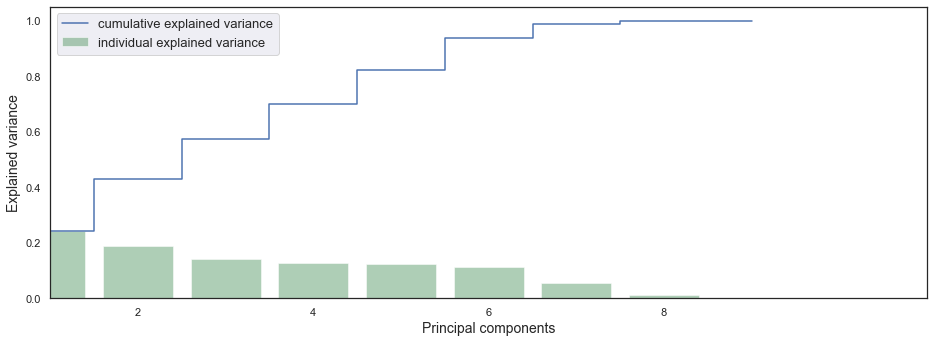

In [63]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

About 90% of the explained variance is explained by 6 principle components.

In [65]:
for n_clusters in range(3,15):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


For n_clusters = 3 The average silhouette_score is : 0.16606377489300503
For n_clusters = 4 The average silhouette_score is : 0.17183202962468405
For n_clusters = 5 The average silhouette_score is : 0.19035227561202542
For n_clusters = 6 The average silhouette_score is : 0.19645448366738094
For n_clusters = 7 The average silhouette_score is : 0.19338018649215757
For n_clusters = 8 The average silhouette_score is : 0.1972920354316245
For n_clusters = 9 The average silhouette_score is : 0.20125928458578407
For n_clusters = 10 The average silhouette_score is : 0.20348850419900574
For n_clusters = 11 The average silhouette_score is : 0.20727801989671232
For n_clusters = 12 The average silhouette_score is : 0.18540833421736705
For n_clusters = 13 The average silhouette_score is : 0.19030118063568302
For n_clusters = 14 The average silhouette_score is : 0.19225398292576557


Based on the above, I decided to go with 11 clusters

In [120]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('Silhouette score: {:<.3f}'.format(silhouette_avg))

Silhouette score: 0.213


Here we can see the number of customers for each cluster:


In [67]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['number of clients']).T

,3,1,7,9,5,0,2,4,10,8,6
number of clients,2305,1118,711,538,402,341,341,74,16,5,4


In [68]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

We then do a representation of the different clusters.

<ipython-input-69-ff4ab8333cea>:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


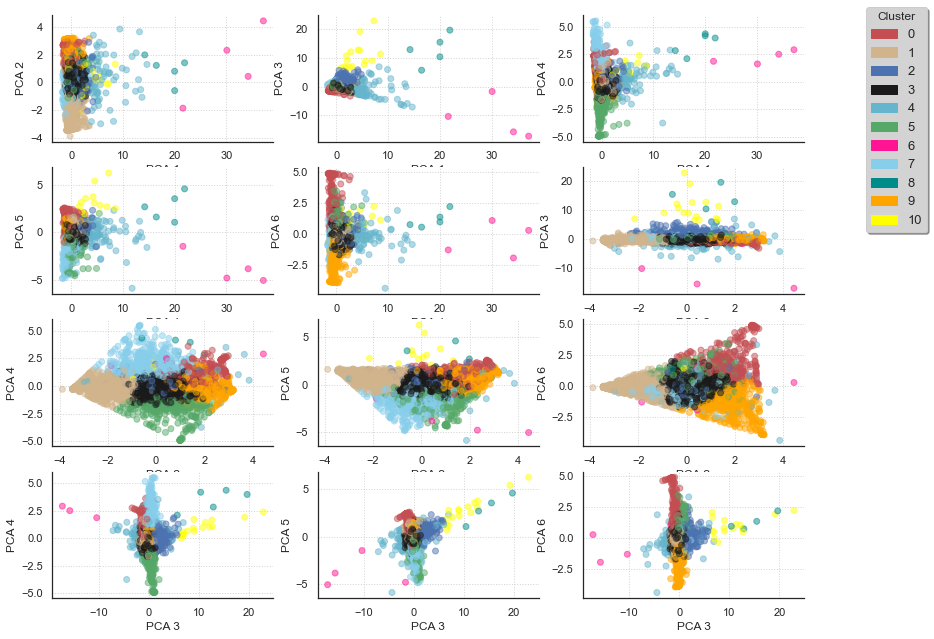

In [69]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
labelColour = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0

for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= labelColour, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
        
comp_handler = []

for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, we can see that at least 3-5 clusters appear to be distinct.

Another method that can be used to look at how good the separation is, is to look at the silhouette scores.


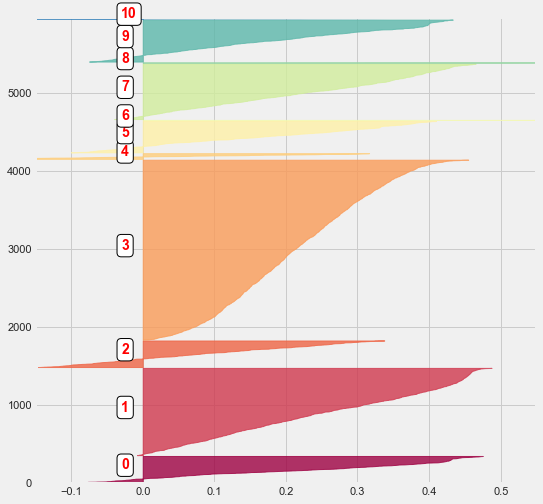

In [70]:
sampleSilhouetteValues = silhouette_samples(scaled_matrix, clusters_clients)

sampleSilhouetteValues = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sampleSilhouetteValues, clusters_clients)

So now we know that the clusters are disjoint. But the objective of understanding the habits of customers in each cluster still needs to be completed. The first step in completing this objective is to introduce a column which represents which cluster customers belong in.

In [71]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of customers. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the customers of the different clusters.


In [72]:
merged_df = pd.DataFrame() 
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('Customer ID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 5855


In [73]:
merged_df

,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
cluster,,,,,,,,,,,,,
0.0,2.903226,177.626422,331.347830,243.812051,760.903695,13.211172,19.066034,54.323482,8.507282,4.895549,255.774194,419.090909,341
5.0,3.191542,195.335527,429.168833,291.487532,1013.550005,21.815078,18.652382,7.224251,47.203141,5.149358,247.895522,422.761194,402
9.0,3.689591,181.605874,387.504238,270.775942,1158.595279,13.567903,59.521982,11.195390,10.530322,5.233166,234.886617,434.249071,538
1.0,3.867621,193.921459,422.503882,291.374413,1165.667586,69.280429,10.761424,4.799223,9.495578,5.680095,246.963327,458.331843,1118
7.0,4.592124,161.782166,403.604866,265.472708,1326.914940,26.899419,16.313462,8.545006,11.260099,36.984490,214.563994,484.382560,711
3.0,4.902820,211.952868,567.636465,366.698212,1763.757317,34.244576,26.324281,13.343865,17.686565,8.407245,174.857267,475.707592,2305
6.0,1.250000,8257.797500,12813.022500,10535.410000,13641.772500,49.733001,6.565885,11.363087,27.660055,4.677972,466.750000,491.000000,4
2.0,28.557185,57.244575,1645.234839,543.909508,13873.418425,37.093378,24.948426,10.760379,18.335714,8.886774,32.862170,671.727273,341
4.0,7.256757,1454.155689,4511.084743,2493.445608,17291.992176,40.119401,25.019004,11.287519,18.475235,5.099269,219.243243,435.040541,74


We have a data frame which represents each customer. We have the cluster that each customer belongs in, the count, min, max, mean, sum, the percentage of how much of their purchased products belongs in each category (this was something that we worked on in the previous section with nltk and the words occurances), and finally, the size. 

In [79]:
list_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 35].index.values[0])

list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]

merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])


,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,1.0,3.867621,193.921459,422.503882,291.374413,1165.667586,69.280429,10.761424,4.799223,9.495578,5.680095,1118
1,9.0,3.689591,181.605874,387.504238,270.775942,1158.595279,13.567903,59.521982,11.195390,10.530322,5.233166,538
2,0.0,2.903226,177.626422,331.347830,243.812051,760.903695,13.211172,19.066034,54.323482,8.507282,4.895549,341
3,5.0,3.191542,195.335527,429.168833,291.487532,1013.550005,21.815078,18.652382,7.224251,47.203141,5.149358,402
4,7.0,4.592124,161.782166,403.604866,265.472708,1326.914940,26.899419,16.313462,8.545006,11.260099,36.984490,711
5,3.0,4.902820,211.952868,567.636465,366.698212,1763.757317,34.244576,26.324281,13.343865,17.686565,8.407245,2305
6,6.0,1.250000,8257.797500,12813.022500,10535.410000,13641.772500,49.733001,6.565885,11.363087,27.660055,4.677972,4
7,2.0,28.557185,57.244575,1645.234839,543.909508,13873.418425,37.093378,24.948426,10.760379,18.335714,8.886774,341
8,4.0,7.256757,1454.155689,4511.084743,2493.445608,17291.992176,40.119401,25.019004,11.287519,18.475235,5.099269,74
9,10.0,169.750000,22.996875,4463.773125,587.186990,92927.095125,39.022955,24.233878,10.635097,18.252146,7.861677,16


In [80]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

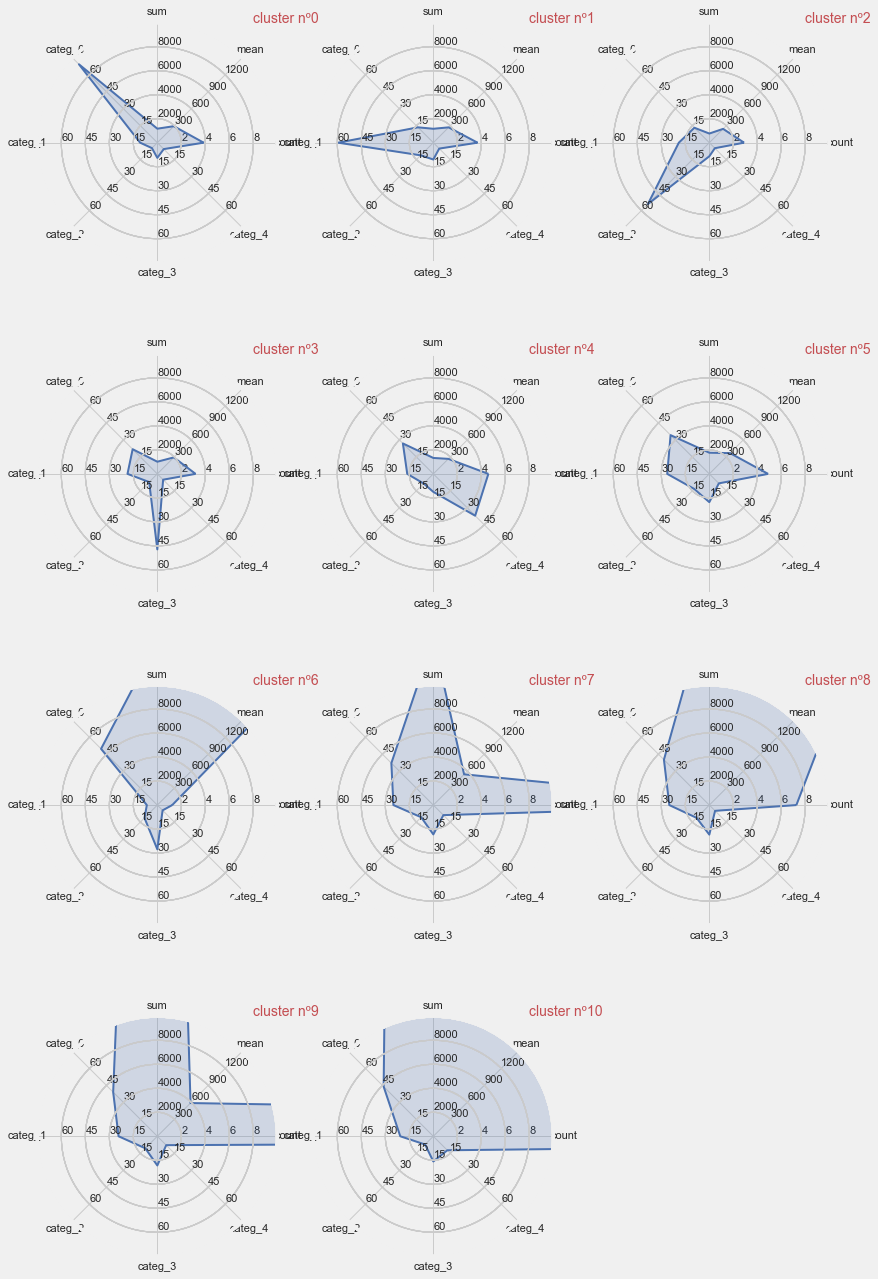

In [82]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

From this, we can see that the first 4 clusters point strongly in the direction of specific product categories. The rest of the clusters seem to differ from cart averages (mean), the total sum spent by the customers (sum) or the total number of visits made (count).

In [84]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [85]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

# **5. Classification of Customers**

The objective of this section is to classify customers into the clusters that were made in the previous section. The variables that relate to after the customer’s first visit will not be dealt with as we want to classify the customers from their first visit. This way of doing things may be convenient and beneficial to the company that sells the products. The company may gain a better understanding of who their customers are and what needs to be done to cater to them according to their initial visits.


In [86]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble

In [87]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

This is the first classifier that will be used. The class Class_Fit will be used and grid_search will be called. The parameters that will be used when calling this method will be the hyperparameters and the number of folds that will be used for cross-validation.


In [88]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

We adjust the classifier to the training data:


In [89]:
svc.grid_fit(X = X_train, Y = Y_train)

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ayaznakhuda/Documents/

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/sit

And we can see the quality of the predictions on the test data:

In [90]:
svc.grid_predict(X_test, Y_test)

Precision: 82.84 % 


The precision given above seems to be in line with the results of other machine learning methods. When different classes were defined, there was an imbalance of the size between the classes. There was a class that had around 39% of the customers and so, it will be interesting to see how the predictions and real values compare to the rest of the different classes. A confusion matrix will be implemented for the comparison.

In [91]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


NameError: name 'itertools' is not defined

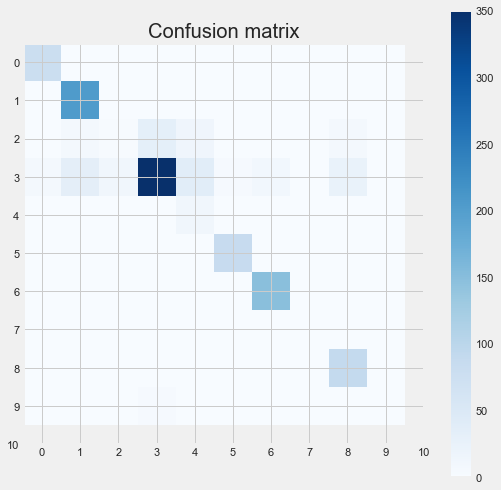

In [92]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

Utilizing learning curves is a way for one to test the quality of a fit for machine learning algorithms that learn from a training dataset incrementally. Over-fitting and under-fitting are common problems associated with models and they can be detected by analyzing learning curves. Learning curves can also tell whether adding more data will benefit the model.  Scikit-learn's code from their documentation will be used. For more information about learning curves, please see: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [93]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


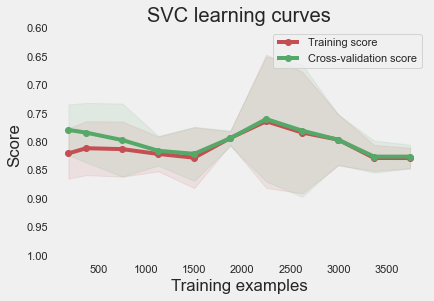

In [94]:
g = plot_learning_curve(svc.grid.best_estimator_,
                    "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                    cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

In the above graph, the training and cross-validation curves converge together as the sample sizes increase. This is something seen in models with low variance and proves that the model is not over-fitting. One can also see that the training score is relatively high which indicates low bias. Thus, the model does not underfit the data.


# **Logistic Regression:**


In [95]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHE

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Precision: 91.80 % 


/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


I then plot the learning curve to get a feel for the quality of the model.

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


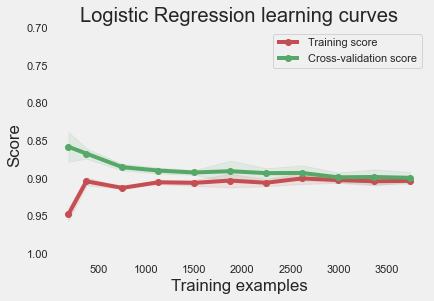

In [96]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# **K-Nearest Neighbours:**


In [97]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Precision: 82.32 % 


# **Decision Tree:**


In [98]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Precision: 84.37 % 


# **Random Forest:**


In [99]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}

In [100]:
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Precision: 91.37 % 


/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


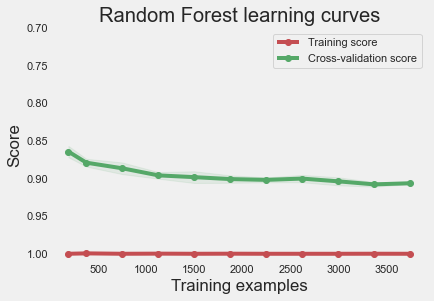

In [101]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# **AdaBoost Classifier:**


In [102]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML

In [103]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Precision: 63.02 % 


/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


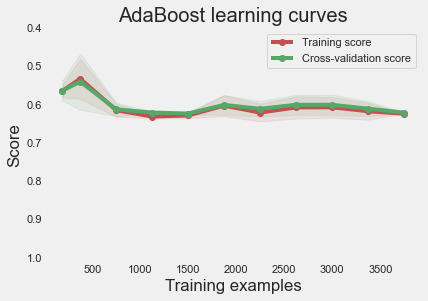

In [104]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# **Gradient Boosting Classifier:**

In [105]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Precision: 90.69 % 


/Users/ayaznakhuda/Documents/ml/my_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


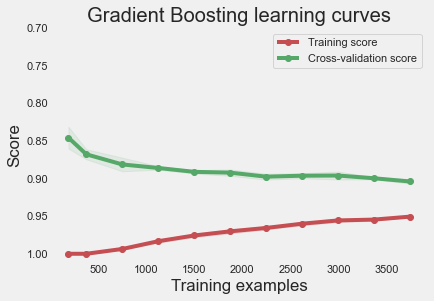

In [106]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

The results obtained from the different classifiers can be combined to improve the classification model.
This is done by selecting the customer category that has been indicated by the majority of the classifiers. The VotingClassifier method in scikit-learn was used. 

In [107]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [108]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft') 

In [109]:
votingC = votingC.fit(X_train, Y_train)

In [110]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.97 % 


In [111]:
basket_price = set_test.copy(deep = True)

# **6. Testing the Predictions**

In the next part of this notebook, I will be working on the last two months of data which is stored in the set_test data frame. The customers in set_test will be classified. Then we will see how well our prediction model made previously, will perform when predicting the categories that customers belong in.

In [112]:
transactions_per_user=basket_price.groupby(by=['Customer ID'])['Cart Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['Customer ID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['Customer ID'])['categ_0'].sum()

transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('Customer ID', ascending = True)[:5]


,Customer ID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,10,224.82,1294.32,759.570000,7595.70,38.022829,14.922917,9.892439,31.573127,5.588688
1,12348.0,5,310.00,310.00,310.000000,1550.00,12.903226,87.096774,0.000000,0.000000,0.000000
2,12349.0,5,1757.55,1757.55,1757.550000,8787.75,53.938722,19.985776,4.513101,8.131774,13.430628
3,12352.0,15,266.25,366.25,314.743333,4721.15,70.978469,20.037491,2.202853,2.883831,3.897356
4,12356.0,5,58.35,58.35,58.350000,291.75,100.000000,0.000000,0.000000,0.000000,0.000000


In [113]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

matrix_test = transactions_per_user[list_cols].values
scaled_test_matrix = scaler.transform(matrix_test)

An important note to mention here is that we are preparing the test data here by defining the category to which the 
customers belong. The classifier defined earlier uses a more restricted set of variables that is defined from the first purchase of a customer.

The test data consists of data from the last two months of this data set. After having the customers classified,  the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the customers belong, I recall the instance of the kmeans method used previously. The predict method of this instance calculates the distance of the consumers from the centroids of the 11 client classes. The smallest distance will determine which category consumers belong in.

In [114]:
Y = kmeans.predict(scaled_test_matrix)

In [115]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

In [116]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]

for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 77.22 % 
______________________________ 
Logostic Regression
Precision: 85.05 % 
______________________________ 
k-Nearest Neighbors
Precision: 76.00 % 
______________________________ 
Decision Tree
Precision: 81.17 % 
______________________________ 
Random Forest
Precision: 85.96 % 
______________________________ 
Gradient Boosting
Precision: 85.62 % 


In [117]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 86.60 % 


# **7. Conclusion**


The work done in this notebook is based on a dataset that provides details on purchases made by customers from the U.K on an e-commerce platform for a period of a year. Each entry describes the purchase of a product by a customer at a certain date. In total, there are 5942 customers who bought 4646 unique products. There were 44876 transactions.

I have decided to develop a classifier which allows for the anticipation of the type of purchase that a customer will make along with the number of visits that they will make during a year, based on their first visit to the e-commerce website.

Stage one of this notebook consisted of decribing the various products sold. This was the first subject of classification. The different products were grouped into 5 main categories. The next step was the classification of customers by analyzing their consumer habits over a period of a year (approx.). 11 customer categories were made based on the products customers purchased, the number of visits and the amount of money that they spent during the 10 months. Then several classifiers which classified customers to 1 of the 11 categories were trained. The variables used for the classifiers were: the mean value of the money spent by each customer and the 
percentage that was spent in each of the 5 product categories.

The prediction quality of the classifiers was tested over the last two months of the dataset. The data was processed in two steps. Firstly, the test data was used to define the category that each customer belongs in. The classifier predictions were then compared to the category assignment. 87% of the customers were given the correct classification. The performance of the classifier seems good given that there is bias. This bias comes from seasonal purchases that people make during Halloween, Chirstmas and Valentine's day. This may cause the categories defined over the 10 month period to be different to those from the last 2 months. A potential fix to this would be more data that covers a longer period of time.